## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import lightgbm as lgb

### Data Load

In [2]:
# 데이터 로드
Total_train = pd.read_csv('../data/Total_train_dataset_27.csv')
Total_test = pd.read_csv('../data/Total_test_dataset_27.csv')

In [3]:
# ID 열을 제외한 특성과 타겟 변수 분리
Total_X = Total_train.drop(['임신_성공_여부', 'ID'], axis=1)
Total_y = Total_train['임신_성공_여부']

### 인코딩 

In [4]:
Total_categorical_columns = [
    "시술_시기_코드",
    "시술_당시_나이",
    "시술_유형",
    "특정_시술_유형",
    "배란_유도_유형",
    "단일_배아_이식_여부",
    "착상_전_유전_진단_사용_여부",
    "배아_생성_주요_이유",
    "총_생성_배아_수",
    "미세주입된_난자_수",
    "미세주입에서_생성된_배아_수",
    "이식된_배아_수",
    "미세주입_배아_이식_수",
    "저장된_배아_수",
    "미세주입_후_저장된_배아_수",
    "해동된_배아_수",
    "해동_난자_수",
    "수집된_신선_난자_수",
    "저장된_신선_난자_수",
    "혼합된_난자_수",
    "파트너_정자와_혼합된_난자_수",
    "기증자_정자와_혼합된_난자_수",
    "난자_출처",
    "정자_출처",
    "난자_기증자_나이",
    "정자_기증자_나이",
    "동결_배아_사용_여부",
    "신선_배아_사용_여부",
    "기증_배아_사용_여부",
    "대리모_여부",
]

In [5]:
# 모든 범주형 변수를 문자열로 변환
Total_X[Total_categorical_columns] = Total_X[Total_categorical_columns].astype(str)
Total_test[Total_categorical_columns] = Total_test[Total_categorical_columns].astype(str)

# OrdinalEncoder를 사용하여 범주형 변수 인코딩
Total_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

Total_X[Total_categorical_columns] = Total_encoder.fit_transform(Total_X[Total_categorical_columns])
Total_test[Total_categorical_columns] = Total_encoder.transform(Total_test[Total_categorical_columns])

## Modeling

In [6]:
# 데이터 분할
Total_X_train, Total_X_test, Total_y_train, Total_y_test = train_test_split(Total_X, Total_y, test_size=0.2, random_state=42)

### Total 데이터

optuna

In [7]:
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 목적 함수 정의
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 5000),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'max_depth': trial.suggest_int('max_depth', -1, 512),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 300),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-8, 1.0, log=True),
        'random_state': 42,
        'boosting_type': 'gbdt',
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**param)
    model.fit(Total_X_train, Total_y_train)
    
    y_pred_proba = model.predict_proba(Total_X_test)[:, 1]
    
    auc = roc_auc_score(Total_y_test, y_pred_proba)
    return auc

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=800)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-02-12 14:20:01,643] A new study created in memory with name: no-name-5e828f62-5442-4328-a5ac-c80247aed324
[I 2025-02-12 14:20:44,564] Trial 0 finished with value: 0.7349321452304292 and parameters: {'n_estimators': 2241, 'num_leaves': 503, 'max_depth': 184, 'learning_rate': 0.007698505167724087, 'min_child_samples': 291, 'subsample': 0.5047602922523404, 'reg_alpha': 1.0444025732872331e-06, 'reg_lambda': 1.2234767160762915e-07, 'min_split_gain': 0.13565733583014017}. Best is trial 0 with value: 0.7349321452304292.
[I 2025-02-12 14:23:09,879] Trial 1 finished with value: 0.7337716249703045 and parameters: {'n_estimators': 4860, 'num_leaves': 293, 'max_depth': 501, 'learning_rate': 0.00012407449076894852, 'min_child_samples': 10, 'subsample': 0.5135680653615244, 'reg_alpha': 0.40708836382849484, 'reg_lambda': 0.004958379405852971, 'min_split_gain': 5.4737803658003e-06}. Best is trial 0 with value: 0.7349321452304292.
[I 2025-02-12 14:23:49,091] Trial 2 finished with value: 0.72908

Best trial:
  Value: 0.7383182981732658
  Params: 
    n_estimators: 3483
    num_leaves: 47
    max_depth: 172
    learning_rate: 0.013251741549079776
    min_child_samples: 294
    subsample: 0.7577624527552422
    reg_alpha: 0.00986620977318458
    reg_lambda: 0.00031909006782891117
    min_split_gain: 0.5389479432523373


최적의 파라미터로 학습


--- Model Performance ---
Model Accuracy: 0.7445044763892411
Model F1 Score: 0.18685207027127693
Model AUC: 0.7379306489208997


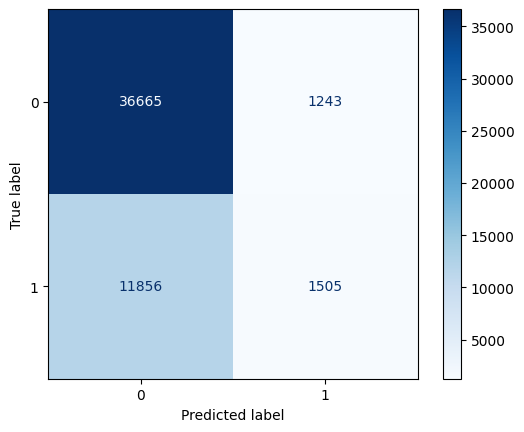

In [25]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 모델 초기화
Total_model = lgb.LGBMClassifier(
    n_estimators=5471,  # 트리의 개수 (부스팅 반복 횟수)
    num_leaves=13,  # 하나의 트리가 가질 수 있는 최대 리프 노드 수
    max_depth=279,  # 트리의 최대 깊이 (-1이면 제한 없음)
    learning_rate=0.007075124517450591,  # 학습률 (0과 1 사이의 값)
    min_child_samples=26,  # 리프 노드가 되기 위한 최소한의 데이터 수
    subsample=0.29772991936701476,  # 각 트리를 학습할 때 사용하는 데이터 샘플링 비율
    colsample_bytree=0.8913054521763838,  # 각 트리를 학습할 때 사용하는 피처 샘플링 비율
    reg_alpha=0.0004860363321690653,  # L1 정규화 (Lasso) 계수
    reg_lambda=311.08056657247363,  # L2 정규화 (Ridge) 계수
    min_split_gain=0.18214905183450955,  # 노드를 분할하기 위한 최소 손실 감소 값
    random_state=42,  # 랜덤 시드 값 (재현성을 위해 설정)
    boosting_type='gbdt',  # 부스팅 유형 ('gbdt', 'dart', 'goss', 'rf' 중 하나)
    verbose=-1  # 학습 과정의 출력을 제어 (음수이면 출력을 억제)
)

# 모델 학습
Total_model.fit(Total_X_train, Total_y_train)

# 예측
y_pred = Total_model.predict(Total_X_test)
y_pred_proba = Total_model.predict_proba(Total_X_test)[:, 1]

# 평가
accuracy = accuracy_score(Total_y_test, y_pred)
f1 = f1_score(Total_y_test, y_pred)
auc = roc_auc_score(Total_y_test, y_pred_proba)
cm = confusion_matrix(Total_y_test, y_pred)

# 결과 출력
print()
print("--- Model Performance ---")
print(f"Model Accuracy: {accuracy}")
print(f"Model F1 Score: {f1}")
print(f"Model AUC: {auc}")

# 혼동 행렬 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Total_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

데이콘 PUBLIC ??

## 제출

In [27]:
# 모델 학습 및 예측
Total_model.fit(Total_X, Total_y)
Total_pred_proba = Total_model.predict_proba(Total_test.drop('ID', axis=1))[:, 1]
Total_test['probability'] = Total_pred_proba

# 최종 제출 파일 생성
submission = Total_test[['ID', 'probability']]
submission = submission.sort_values(by='ID')

In [ ]:
# 제출 파일 저장
submission.to_csv('../submission/code24_total_submit.csv', index=False, encoding='utf-8')

In [32]:
import pandas as pd

# 두 CSV 파일을 읽어옵니다.
df1 = pd.read_csv('../submission/code24_submit.csv')
df2 = pd.read_csv('../submission/code24_total_submit.csv')

# ID를 기준으로 병합합니다.
merged_df = pd.merge(df1, df2, on='ID', suffixes=('_df1', '_df2'))

# 'probability' 열을 소프트 보팅하여 새로운 'probability' 열 생성
merged_df['probability'] = (merged_df['probability_df1'] + merged_df['probability_df2']) / 2

# 최종 제출 파일 생성
submission = merged_df[['ID', 'probability']]
submission = submission.sort_values(by='ID')

# 제출 파일 저장
submission.to_csv('../submission/code24_soft_voting_submit.csv', index=False, encoding='utf-8')

데이콘 PUBLIC ??

.